In [2]:
##### This Jupyter notebook first calculates pairwise distances using the coordinates of selected residues, 
##### and then removes and selects features using variances
##### Please ensure you have properly set up the conda environment with all libraries.

##### Author: MO (latest update: Aug 18, 2023)
##### Updated: MR (latest update: May 28, 2024) 

In [5]:
##### User inputs #####
##### Only change if using your own system. If using our inputs, no need to change.

nDataPoints = 754  # Number of data points for each class (*note: each class should have the same number of data points)
dataset = 'PATH_TO/sample_CA_coords.csv'  # Dataset to analyze
nclasses = 3  # Number of classes in the dataset
# i.e., for MFSD2A, it is 3 classes: OFS, OcS, IFS
varThresh = 1.71
# This will be calculated in script step 3.2. Re-run step 3 once the accurate threshold is calculated

In [6]:
### STEP 0. Import libraries
import amino_fast_mod as amino
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import multiprocessing
import kneed

In [7]:
### STEP 1. Load input data (coordinates)
gc.collect()
df = pd.read_csv(dataset)
df.dropna(how='all', axis=1, inplace=True)
varListCoord = df.columns.tolist()
nRes = int(len(varListCoord) / 3)
print("We have", nRes, "residues in total.")

We have 330 residues in total.


In [8]:
### STEP 2. Calculate pairwise distances
varListDist = []
for x in range(nRes):
    resid1 = varListCoord[3*x]
    resid1 = resid1[:-2]
    for y in range(x+1,nRes):
        resid2 = varListCoord[3*y]
        resid2 = resid2[3:-2]
        varDist = "{}.{}".format(resid1, resid2)
        varListDist.append(varDist)

dfDist = pd.DataFrame(columns=varListDist)

In [9]:
for x in range(nRes-1):
    resid1x = varListCoord[3*x]
    resid1y = varListCoord[3*x+1]
    resid1z = varListCoord[3*x+2]
    for y in range(x+1,nRes):
        resid2x = varListCoord[3*y]
        resid2y = varListCoord[3*y+1]
        resid2z = varListCoord[3*y+2]
        varDist = "{}.{}".format(resid1x[:-2], resid2x[3:-2])
        dfDist[varDist] = np.sqrt(((df[resid1x]-df[resid2x])**2) + ((df[resid1y]-df[resid2y])**2) + ((df[resid1z]-df[resid2z])**2))

In [10]:
del df
del varListCoord
del varListDist

In [17]:
### STEP 3. Remove columns with low variance (remove constant and quasi-constant columns)
gc.collect()
var_thres = VarianceThreshold(threshold=varThresh) 
var_thres.fit(dfDist)
new_cols = var_thres.get_support()
concol = [column for column in dfDist.columns if column not in dfDist.columns[new_cols]]
variance_values = dfDist.var()
print("We have", len(concol), "columns with low variance.")
print("Out of", len(variance_values), "total columns.")

We have 37422 columns with low variance.
Out of 54285 total columns.


In [18]:
### STEP 3.1 Plot for Variance vs Number of Features (pairwise distance)
### Author: MR (latest update: May 28, 2024) 

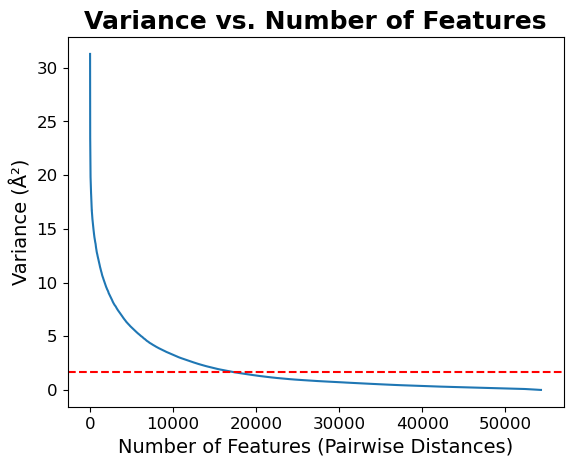

In [19]:
variance_values = dfDist.var()
variance_plot = sorted(variance_values, reverse=True)

plt.plot(variance_plot)
# Edit according to new threshold 
plt.axhline(y=1.71, color='r', linestyle='--')
plt.xlabel('Number of Features (Pairwise Distances)', fontsize=14)
plt.ylabel('Variance (Å²)', fontsize=14)
plt.title('Variance vs. Number of Features', fontweight='bold', fontsize=18)
# Edit according to new threshold 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig('./variance_CA.pdf', dpi=300)
plt.show()

In [20]:
### STEP 3.2 Calculate varThresh 
### Author: MR (latest update: May 28, 2024) 
### Using the Kneedle Algorithm (reference: 'Finding a "Kneedle" in a Haystack: Detecting Knee Points in System Behavior') 
### Will calculate the elbow point, where the variance plateau begins and this will be our varThresh

In [21]:
from kneed import KneeLocator

x = range(1, len(variance_plot) + 1)

# Find the knee point
knee_locator = KneeLocator(x, variance_plot, curve='convex', direction='decreasing', S=100)
knee_point = knee_locator.knee  # This is the x value of the knee point

print(f"The knee point is at x (nFeat) = {knee_point}, and score of: {knee_locator.knee_y}")

The knee point is at x (nFeat) = 16841, and score of: 1.714747182466236


In [22]:
### Drop columns without threshold 

In [23]:
dfReduced = dfDist.drop(concol,axis=1)
dfReduced.shape

(2262, 16863)

In [27]:
### STEP 4. Add classes and export as csv 
### Author: MR (latest update: May 28, 2024) 

In [25]:
zeroList = [0]*nDataPoints # class 1
oneList = [1]*nDataPoints # class 2
twoList = [2]*nDataPoints # class 3
dfReduced['class'] = np.array(zeroList + oneList + twoList)
dfReduced.to_csv('sample_CA_post_variance.csv', index=False)

/tmp/ipykernel_112/1100445754.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfReduced['class'] = np.array(zeroList + oneList + twoList)


In [26]:
dfReduced

,res39.137,res39.166,res39.167,res39.199,res39.201,res39.202,res39.233,res39.292,res39.293,res39.294,...,res472.491,res476.491,res477.491,res480.491,res481.491,res483.491,res484.491,res487.491,res488.491,class
0,48.516654,15.550879,11.782464,30.720754,36.832815,39.005820,47.006240,39.321359,36.689536,33.942176,...,30.878408,25.264388,23.555946,19.585102,17.624119,15.016122,13.801543,8.455018,8.115905,0
1,48.391578,15.821387,12.044111,32.146361,38.290039,39.929612,48.520857,35.755806,34.992586,33.156242,...,31.000032,26.593679,24.836052,20.399656,18.600287,15.646685,14.316205,9.584594,7.850335,0
2,48.898433,15.792147,12.199005,30.827692,36.019894,37.502753,46.577420,37.043157,33.935063,32.014517,...,29.571971,26.101338,24.007810,20.054880,17.730764,15.170421,13.881688,9.780254,7.825675,0
3,48.987007,15.815029,12.134304,31.922840,37.438372,38.124749,47.552086,34.514976,34.012088,32.750779,...,29.877113,25.897959,24.251504,20.081663,18.004194,15.031151,14.023508,9.551396,7.828224,0
4,50.778727,16.264586,12.559692,31.695209,37.816740,38.221784,47.203244,38.106838,37.139492,34.704269,...,29.727102,26.274326,24.131379,19.703288,17.837260,15.216900,13.649606,9.804452,7.693616,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,46.749142,13.288223,9.803680,32.612726,37.012895,38.300388,47.556014,43.548585,43.659433,40.167670,...,27.269869,22.993735,21.422974,16.686213,14.928687,12.062921,10.524907,6.062552,5.134690,2
2258,46.792536,13.969725,10.455201,32.990426,37.222045,38.535049,47.616553,41.644814,42.562491,39.068258,...,26.681468,22.503795,20.751810,16.736734,14.995892,12.388268,10.567933,6.428710,5.301362,2
2259,47.176977,13.284322,9.739256,32.111101,36.319202,37.142845,47.058533,43.688228,43.763872,40.519359,...,27.728934,23.740447,22.090317,17.511157,15.829649,12.607925,11.031930,6.645588,5.484716,2
2260,46.678082,14.040287,10.573478,32.101427,35.989655,37.122386,47.024755,44.893687,44.846179,41.329235,...,27.437300,23.264725,21.579145,16.790344,15.274260,12.411037,10.922860,6.239806,5.221792,2
